<a href="https://colab.research.google.com/github/richardplambeck/python/blob/master/OptimizeAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this exercise is to calculate the typical performance of a 2-layer thermal spray AR coating on alumina, allowing for realistic variations in the coating thicknesses and refractive indices.

Transmission through a stack of dielectric layers will be calculated using the following function, based on the characteristic matrix method outlined in section 9.7 of Jenkins and White.

Input parameters:
* fGHzArr = list of frequencies (in GHz) at which to compute the transmission
* params = [t1, n1, tanDelta1, t2, n2, tanDelta2, ... tN, nN, tanDeltaN], where t is the layer thickness in inches, n is the refractive index, and tanDelta is the loss tangent for each of the N layers in the stack (for this calculation I will assume tanDelta=0 for all layers).

Returns:
* array of power transmissions

In [2]:
import numpy
import math

clight = 29.9792458     # speed of light, cm/nanosec = cm-GHz

def solveStack( fGHzArr, params) :
    Y0 = 1
    k0array = -2. * math.pi *fGHzArr / clight           # array of wavenumbers

  # this is a tricky way of making an array of identity matrices  
    M = numpy.zeros(4*len(k0array))
    M[0:None:4] = 1
    M[3:None:4] = 1
    M2 = numpy.reshape(M, (-1,2,2))

  # step through the layers; param[i]=thickness in inches, param[i+1]=nrefrac; param[i+2]=tanDelta
    for i in range(0,len(params),3) :
      ncomplex = params[i+1] * (1. + 1j * params[i+2]/2.)
      h = ncomplex * 2.54 * params[i]
      Y1 = ncomplex
      M1 = [[numpy.cos(k0array*h), 1j*numpy.sin(k0array*h)/Y1],[1j*Y1*numpy.sin(k0array*h),numpy.cos(k0array*h)]]
      M2 = numpy.matmul( numpy.moveaxis(M1,2,0), M2)
               # M1 has shape (2,2,nfreq); reorder to get desired shape (nfreq,2,2)
    denom = numpy.sum( numpy.sum(M2,axis=2), axis=1 )
               # array of nfreq denominators, each the sum of the elements of the 2x2 matrix
    trans = 2.*Y0/denom
    pwr = numpy.power( numpy.abs(trans), 2)
    return pwr


As a sanity check, compute the transmission for a simple lambda/4 coating. 

coating thickness = 0.0186", index = 1.766


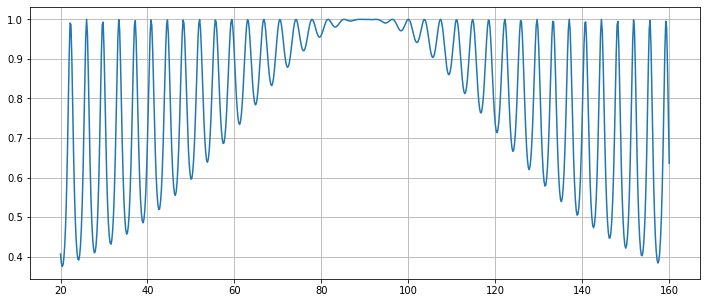

In [3]:
import matplotlib.pyplot as pyplot
pyplot.rcParams['figure.figsize'] = [12,5]

n_alumina = 3.12
t_alumina = 0.5
n_coating = math.sqrt(n_alumina)
fGHz_center = 90.
t_coating = (clight/fGHz_center)/2.54/n_coating/4.
print("coating thickness = %.4f\", index = %.3f" % (t_coating,n_coating))
fGHzArr = numpy.arange(20., 160.01,.2)
param = [ t_coating, n_coating, 0., t_alumina, n_alumina, 0., t_coating, n_coating, 0.]
trans = solveStack( fGHzArr, param)
pyplot.plot(fGHzArr,trans)
pyplot.grid()

Now compute the optimum parameters for a 2-layer AR coating, maximizing the power transmission in 2 frequency bands, 74-104 GHz ("band1") and 126-166 GHz ("band 2").

I am going to do this with emcee, an MCMC code, closely following the procedure outlined in https://emcee.readthedocs.io/en/stable/tutorials/line/. The "data" is the ideal transmission (1.00) in the two frequency bands.  The goal is to "fit" the data by varying the AR coating parameters.  For this to work, we need to specify an uncertainty in the data.  The exact value doesn't matter; I will choose an uncertainty of 0.02.  

In [4]:
# define the frequency bands
band1 = [74.,104.]
band2 = [126.,166.]

# the "data" span only these two frequency ranges; we don't care what happens at other freqs
deltaf = .2
fGHzBand1 = numpy.arange( band1[0], band1[1]+.001, deltaf)
fGHzBand2 = numpy.arange( band2[0], band2[1]+.001, deltaf)
fGHzArr = numpy.append( fGHzBand1, fGHzBand2 )

# the uncertainties can be set separately for the 2 bands, if desired
uncBand1 = .02 * numpy.ones(len(fGHzBand1))
uncBand2 = .02 * numpy.ones(len(fGHzBand2))
unc = numpy.append( uncBand1, uncBand2 )


The next step is to define log_likelihood and log_prior functions.  The log_likelihood is basically chisq, while the log_prior function encodes previous knowledge of the parameters.  I will set this up to use flat priors for all parameters (any value between min and max is OK).

In [24]:
 fitParams = { "label" : ["t1","n1","t2","n2"], \
              "paramMin" : [.016, 1.2, .008, 2.1],
              "paramMax" : [.025, 1.8, .015, 2.5] }

def log_likelihood(param, fitParams, fGHzArr ) :
    fullset = [param[0],param[1],0.,param[2],param[3],0.0,t_alumina,n_alumina,0.,param[2],param[3],0.0,param[0],param[1],0.]
    trans = solveStack( fGHzArr, fullset )
    ideal = numpy.ones(len(trans))         # this is the "data"
    sigma2 = numpy.power(unc,2)
    return -0.5 * numpy.sum(numpy.power(trans - ideal,2)/sigma2)

def log_prior(param, fitParams ):
    for i in range(0,len(param)) :
      if param[i] < fitParams["paramMin"][i] or param[i] > fitParams["paramMax"][i] :
        return -numpy.inf
          # log(-inf) = 0, indicating one or more parameters are outside the allowed range
    return 0.    
          # log(0) = 1, indicating parameters all are in the allowed range  
      
def log_probability(param, fitParams, fGHzArr) :
    lp = log_prior( param, fitParams)
    if not numpy.isfinite(lp) :
      return -numpy.inf
    return lp + log_likelihood(param, fitParams, fGHzArr)

Now make sure emcee is installed (this needs to be done once each session) and begin MCMC with all parameters at the midpoints of their ranges.  After 1000 iterations, plot the sample chain to make sure it converged.

100%|██████████| 2000/2000 [01:01<00:00, 32.75it/s]


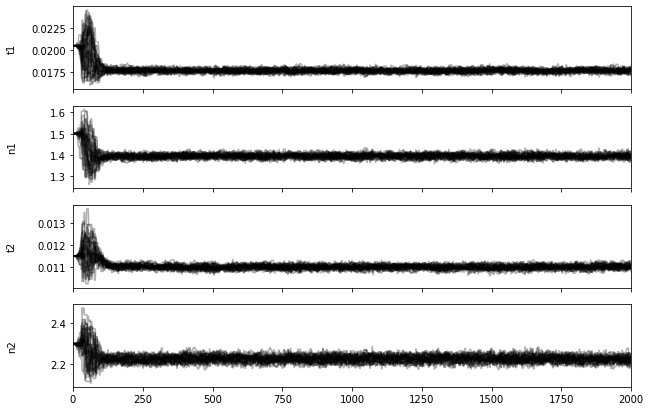

In [25]:
!pip install emcee
!pip install corner
import emcee
import corner
from google.colab import files

# initial guess for parameters is midpoint of allowed range
paramStart = numpy.average( [fitParams["paramMin"],fitParams["paramMax"]], axis=0 )
ndim = len(paramStart)
nwalkers = 32
param = paramStart * (1. + 1e-4 * numpy.random.randn(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(fitParams,fGHzArr))
sampler.run_mcmc(param, 2000, progress=True)

fig, axes = pyplot.subplots(4, figsize=(10,7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
  ax = axes[i]
  ax.plot(samples[:, :, i], "k", alpha=0.3)
  ax.set_xlim(0, len(samples))
  ax.set_ylabel( fitParams["label"][i] )
  ax.yaxis.set_label_coords(-0.1, 0.5)
pyplot.show()


One can make a corner plot to check on covariances between parameters if desired.

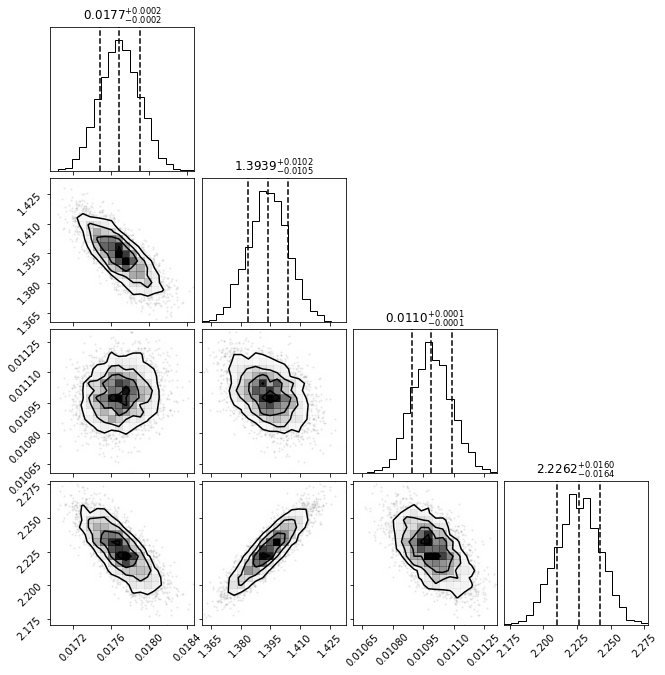

In [26]:
# corner plot
flat_samples = sampler.get_chain(discard=250, thin=15, flat=True)
fig = corner.corner(flat_samples, quantiles=[0.16,0.5,0.84],
show_titles=True, title_fmt=".4f" )


List the best fit values and estimated uncertainties.

In [27]:
flat_samples = sampler.get_chain(discard=200, thin=15, flat=True)
optimum = numpy.zeros(ndim)
errminus = numpy.zeros(ndim)
errplus = numpy.zeros(ndim)
for i in range(ndim) :
  mcmc = numpy.percentile(flat_samples[:, i], [16, 50, 84])
  optimum[i] = mcmc[1]
  errminus[i] = mcmc[0]-mcmc[1]
  errplus[i] = mcmc[2]-mcmc[1]
  print ("%8s  %.5f (%.5f,+%.5f)" % (fitParams["label"][i],optimum[i],errminus[i],errplus[i]))


      t1  0.01769 (-0.00020,+0.00021)
      n1  1.39373 (-0.01011,+0.01042)
      t2  0.01099 (-0.00009,+0.00010)
      n2  2.22589 (-0.01633,+0.01567)


I ran the calculation twice, first allowing the Fillite refractive index (n1) to be unconstrained (min allowed value of 1.3), then constraining it to be >= 1.5.  The results are transcribed below (note that since this is an MCMC calculation, the numbers will change slightly each time the code is run).

In [28]:
# optimum parameters if Fillite index is unconstrained:
t1_a = .0177
n1_a = 1.394
t2_a = .0110
n2_a = 2.226

# best parameters if Fillite index is constrained to be >= 1.5:
t1_b = .0163
n1_b = 1.500
t2_b = .0106
n2_b = 2.359


Plot the transmission curves for the two cases.

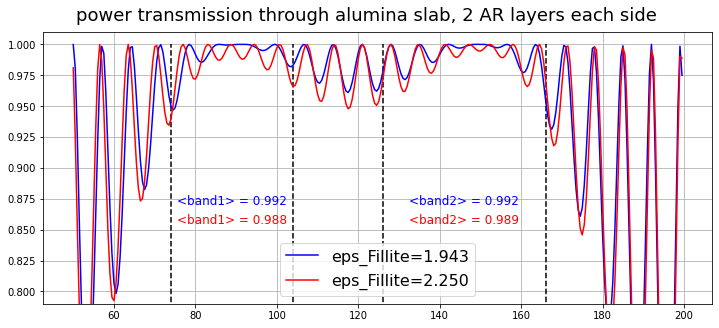

In [34]:
t_alumina = 0.25
param_a = [t1_a,n1_a,0., t2_a,n2_a,0., t_alumina,n_alumina,0., t2_a,n2_a,0., t1_a,n1_a,0.]
param_b = [t1_b,n1_b,0., t2_b,n2_b,0., t_alumina,n_alumina,0., t2_b,n2_b,0., t1_b,n1_b,0.]

fGHzArr = numpy.arange(50.,200.,.5)
iband1 = numpy.rint( (band1-fGHzArr[0]) / (fGHzArr[1]-fGHzArr[0])).astype(int)
iband2 = numpy.rint( (band2-fGHzArr[0]) / (fGHzArr[1]-fGHzArr[0])).astype(int)
   # iband[0] is lower edge of band in fGHzArr, iband[1] is upper edge
trans_a = solveStack( fGHzArr, param_a)
trans_b = solveStack( fGHzArr, param_b)
pyplot.plot(fGHzArr, trans_a, 'blue', label="eps_Fillite=%.3f" % numpy.power(n1_a,2))
pyplot.plot(fGHzArr, trans_b, 'red', label="eps_Fillite=%.3f" % numpy.power(n1_b,2))
band1_avg_a = numpy.average( trans_a[iband1[0]:iband1[1]] )
band2_avg_a = numpy.average( trans_a[iband2[0]:iband2[1]] )
band1_avg_b = numpy.average( trans_b[iband1[0]:iband1[1]] )
band2_avg_b = numpy.average( trans_b[iband2[0]:iband2[1]] )
pyplot.ylim(.79,1.01)
pyplot.vlines( band1, 0., 1., color='black', linestyles='dashed')
pyplot.text( numpy.average(band1), .87, "<band1> = %.3f" % band1_avg_a, \
            ha='center', color='blue', fontsize=12)
pyplot.text( numpy.average(band1), .855, "<band1> = %.3f" % band1_avg_b, \
            ha='center', color='red', fontsize=12)
pyplot.vlines( band2, 0., 1., color='black', linestyles='dashed')
pyplot.text( numpy.average(band2), .87, "<band2> = %.3f" % band2_avg_a, \
            ha='center', color='blue', fontsize=12)
pyplot.text( numpy.average(band2), .855, "<band2> = %.3f" % band2_avg_b, \
            ha='center', color='red', fontsize=12)
pyplot.suptitle("power transmission through alumina slab, 2 AR layers each side", fontsize=18, y=.95)
pyplot.legend( fontsize=16)
pyplot.grid()

Suppose we now allow the coating thicknesses and refractive indices to have a Gaussian distributions around their "case b" (epsilon_Fillite = 2.25) values. I'll assume that the coatings on each side of the alumina have independent errors -- that is, the refractive index and thickness of the Fillite coating on side 1 are independent of the refractive index and thickness on side 2. Begin by creating the thickness and index distributions and plotting them as histograms.  I am specifying the scatter on the refractive index but will plot the distribution of dielectric constants, since that's what we talk about much of the time.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

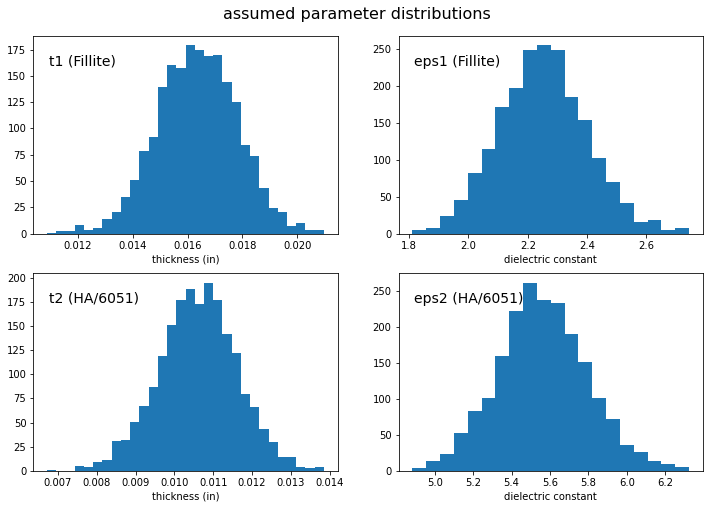

In [97]:
ntrials = 1000
t1 = t1_b + .0015 * numpy.random.randn(2*ntrials)
n1 = n1_b + .05 * numpy.random.randn(2*ntrials)
t2 = t2_b + .001 * numpy.random.randn(2*ntrials)
n2 = n2_b + .05 * numpy.random.randn(2*ntrials)
fig,ax = pyplot.subplots(nrows=2, ncols=2, figsize=[12,8] )
ax[0,0].hist(t1, bins=30)
ax[0,0].text(.05,.85,"t1 (Fillite)", transform=ax[0,0].transAxes, ha='left', fontsize=14)
ax[0,0].set_xlabel("thickness (in)")
ax[1,0].hist(t2, bins=30)
ax[1,0].text(.05,.85,"t2 (HA/6051)", transform=ax[1,0].transAxes, ha='left', fontsize=14)
ax[1,0].set_xlabel("thickness (in)")
ax[0,1].hist(numpy.power(n1,2),bins=20)
ax[0,1].text(.05,.85,"eps1 (Fillite)", transform=ax[0,1].transAxes, ha='left', fontsize=14)
ax[0,1].set_xlabel("dielectric constant")
ax[1,1].hist(numpy.power(n2,2), bins=20)
ax[1,1].text(.05,.85,"eps2 (HA/6051)", transform=ax[1,1].transAxes, ha='left', fontsize=14)
ax[1,1].set_xlabel("dielectric constant")
fig.suptitle("assumed parameter distributions", y=0.93, fontsize=16)
pyplot.savefig("assumed_parameter_distributions.pdf")
files.download('assumed_parameter_distributions.pdf')     
   # download this file for future reference

Plot power transmission curves for a few samples drawn from this population.

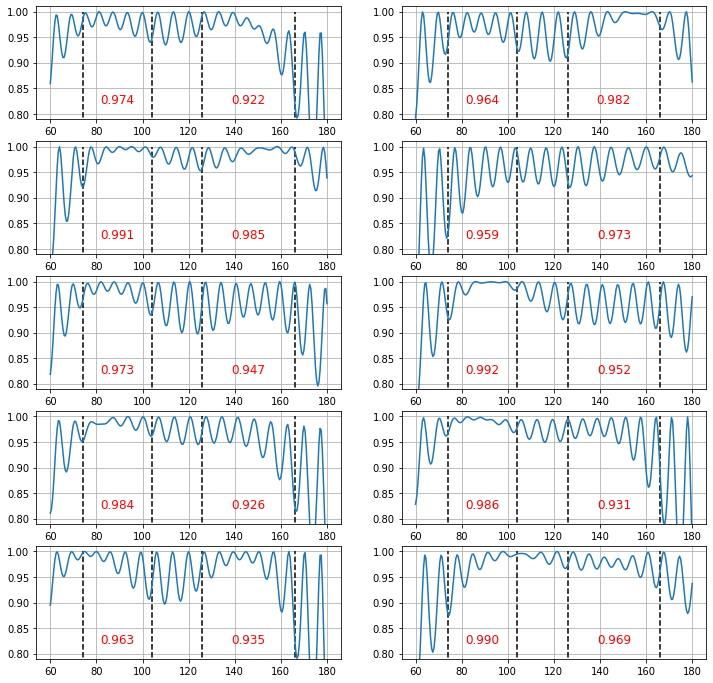

In [98]:
fig,ax = pyplot.subplots( nrows=5, ncols=2, figsize=[12,12] )
fGHzArr = numpy.arange(60.,180.01,.5)
for i in range(0,10) :
  param = [t1[i],n1[i],0.,t2[i],n2[i],0.,t_alumina,n_alumina,0.,t2[i+10],n2[i+10],0.,t1[i+10],n1[i+10],0.]
  trans = solveStack( fGHzArr, param)
  ncol = round((i+1)/10)
  nrow = i - 5*ncol
  ax[nrow,ncol].plot(fGHzArr, trans)
  ax[nrow,ncol].set_ylim(.79,1.01)
  ax[nrow,ncol].vlines( band1, 0., 1., color='black', linestyles='dashed')
  ax[nrow,ncol].vlines( band2, 0., 1., color='black', linestyles='dashed')
  ax[nrow,ncol].grid(True)
  ax[nrow,ncol].text( numpy.average(band1), .82, "%.3f" % numpy.average(trans[iband1[0]:iband1[1]]),
            ha='center', color='red', fontsize=12)
  ax[nrow,ncol].text( numpy.average(band2), .82, "%.3f" % numpy.average(trans[iband2[0]:iband2[1]],),
            ha='center', color='red', fontsize=12)

Now run for 1000 iterations, plot average transmission.  Save list of band1 and band2 transmissions for histogram plot.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

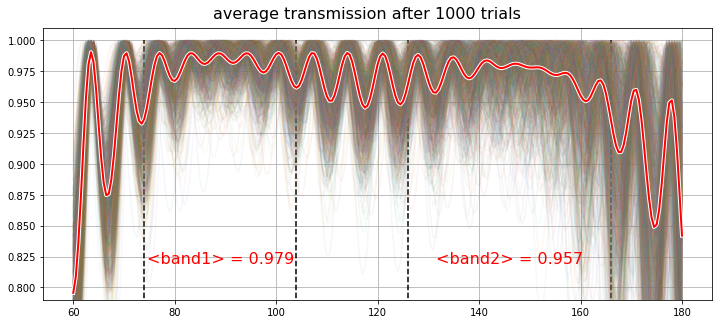

In [99]:
transavg = numpy.zeros(len(fGHzArr))
transb1 = []
transb2 = []

# assume independent errors for coatings on each side (there are 2*ntrials samples for t,n)
for i in range(0,ntrials) :
  param = [t1[i],n1[i],0.,t2[i],n2[i],0.,t_alumina,n_alumina,0.,
           t2[i+ntrials],n2[i+ntrials],0.,t1[i+ntrials],n1[i+ntrials],0.]
  trans = solveStack( fGHzArr, param)
  transavg += trans
  transb1.append( numpy.average( trans[iband1[0]:iband1[1]]) )
  transb2.append( numpy.average( trans[iband2[0]:iband2[1]]) )
  pyplot.plot(fGHzArr,trans, alpha=.05)
pyplot.plot( fGHzArr, transavg/ntrials, lw=4, color='white' )
pyplot.plot( fGHzArr, transavg/ntrials, lw=2, color='red' )
pyplot.ylim(0.79,1.01)
pyplot.grid()
pyplot.vlines( band1, 0., 1., color='black', linestyles='dashed')
pyplot.text( numpy.average(band1), .82, "<band1> = %.3f" % numpy.average(transb1), \
            ha='center', color='red', fontsize=16)
pyplot.vlines( band2, 0., 1., color='black', linestyles='dashed')
pyplot.text( numpy.average(band2), .82, "<band2> = %.3f" % numpy.average(transb2), \
            ha='center', color='red', fontsize=16)
pyplot.suptitle("average transmission after %d trials" % ntrials, y=.94, fontsize=16)
pyplot.savefig("avg_transmission.pdf")
files.download("avg_transmission.pdf")


Finally, plot histograms of the band1 and band2 transmissions.

0.9618092942895625 0.91342476343084


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

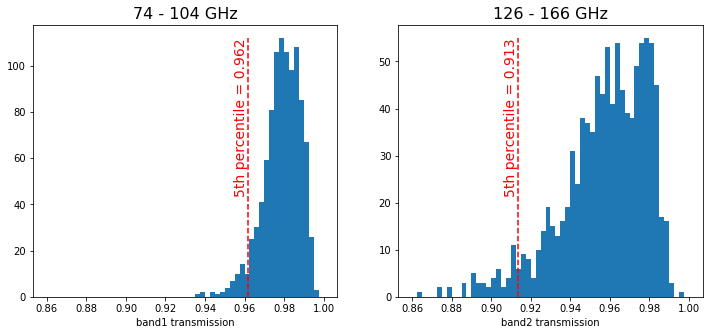

In [101]:
p1 = numpy.sort(transb1)[round(ntrials/20)]
p2 = numpy.sort(transb2)[round(ntrials/20)]
print(p1,p2)
fig,ax = pyplot.subplots(nrows=1,ncols=2)
n,bins,patches = ax[0].hist(transb1, bins=numpy.arange(.86,1.001,.0025), cumulative=False, log=False)
ax[0].vlines(p1, 0., n.max(), linestyle='dashed', color='red')
ax[0].text(p1, n.max(), "5th percentile = %.3f" % p1, rotation='vertical', color='red',
           va='top', ha='right', fontsize=14)
ax[0].set_xlabel('band1 transmission')
ax[0].set_title("%d - %d GHz" % (band1[0],band1[1]), fontsize=16)
n,bins,patches = ax[1].hist(transb2, bins=numpy.arange(.86,1.001,.0025), cumulative=False, log=False)
ax[1].vlines(p2, 0., n.max(), linestyle='dashed', color='red')
ax[1].text(p2, n.max(), "5th percentile = %.3f" % p2, rotation='vertical', color='red',
           va='top', ha='right', fontsize=14)
ax[1].set_xlabel("band2 transmission")
ax[1].set_title("%d - %d GHz" % (band2[0],band2[1]), fontsize=16)
pyplot.savefig("transmission_histograms.pdf")
files.download("transmission_histograms.pdf")